Привет, меня зовут Артем Хуршудов. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Молодец, что структурируешь ноутбук. Приятно проверять такие работы.
* В работе допущена одна ошибка, однако работа все равно будет зачтена. Так как потому, как далее были выбраны параметры видно, что соответствующий анализ был произведен.
* Пожалуйста, в следующий раз проведи этот анализ более явно.
* За исключением этого замечания работу можно будет назвать идеальной.
* Проект зачтен. Удачи в дальнейшем обучении.


## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

SEED = 3021995

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [43]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')

print(data.info())
print()
print(data)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]


<div class="alert alert-block alert-success">
<b>Успех:</b> Загрузка данных и их первичный анализ проведены хорошо.
</div>

Данные временного ряда записаны с диапазоном в 10 минут. Для предложеной задачи можно масштабировать до часа. Для этого необходимо проверить, последовательны ли записи в данном временном ряду:

In [44]:
print('Последовательность ряда:', data.index.is_monotonic)
print('Первая запись:',data.index.min())
print('Последняя запись:', data.index.min())

Последовательность ряда: True
Первая запись: 2018-03-01 00:00:00
Последняя запись: 2018-03-01 00:00:00


Ряд последователен, можно ресэмплировать.

In [45]:
data = data.resample('1H').sum()
print(data)

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[4416 rows x 1 columns]


<div class="alert alert-block alert-success">
<b>Успех:</b> Молодец, что сделал эту проверку. Ресемплинг был произведен корректно!
</div>

# 2. Анализ

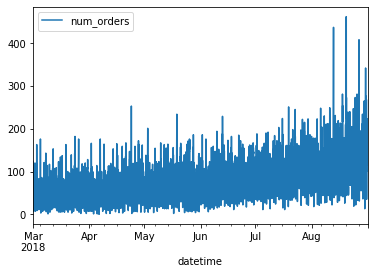

In [46]:
data.plot()

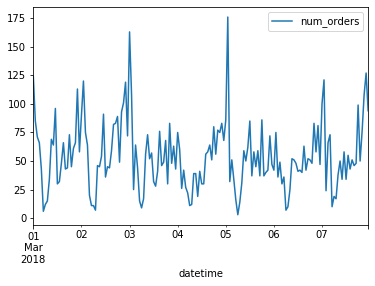

In [47]:
data.head(24*7).plot()

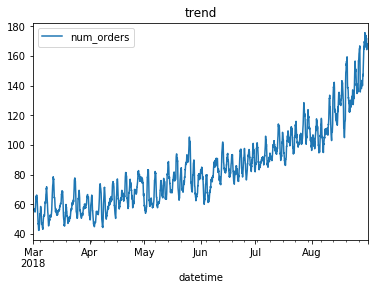

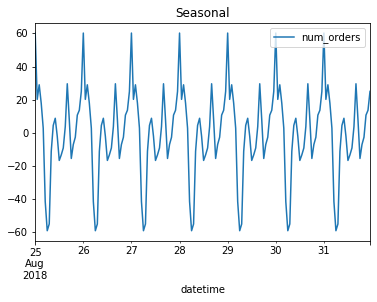

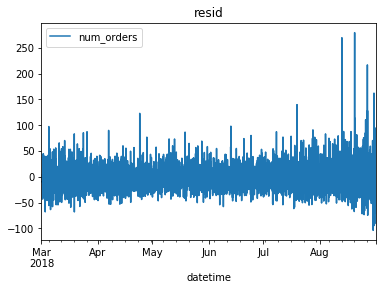

In [48]:
decomposed_data = seasonal_decompose(data)
decomposed_data.trend.plot(title='trend')
decomposed_data.seasonal.tail(24*7).plot(title='Seasonal')
decomposed_data.resid.plot(title='resid')

<div class="alert alert-block alert-success">
<b>Успех:</b> Визуализация сделана очень хорошо. Радует, что было произведено разложение на тренд/сезонность/остаток и нарисованы соответствующие графики.
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> На этом шаге необходимо сделать какие-то выводы по графикам. Наблюдается ли тренд и/или сезонность?
</div>

# 3. Обучение

In [49]:
# метрика - корень из mse
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse = make_scorer(root_mean_squared_error, greater_is_better=False)

<div class="alert alert-block alert-success">
<b>Успех:</b> Радует, что была определена эта функция!
</div>

In [62]:
class FeaturesMaker(TransformerMixin, BaseEstimator):
    
    def __init__(self,
               max_lag,
               rolling_mean_size,
               target,
               is_year=True,
               is_month=True,
               is_day=True,
               is_dayofweek=True,
               is_hour=True,
               fillna=True):
    
        self.max_lag = max_lag
        self.rolling_mean_size = rolling_mean_size
        self.target = target
        self.is_year = is_year
        self.is_month = is_month
        self.is_day = is_day
        self.is_dayofweek = is_dayofweek
        self.is_hour = is_hour
        self.fillna = fillna
    
    def fit(self, X, y=None):
        self.X_ = X.drop(columns=self.target)
        self.y_ = X[self.target]
        return self
    
    def transform(self, X):
        temp = X.copy()
        for lag in range(self.max_lag):
            temp['lag_{}'.format(lag)] = temp[self.target].shift(lag+1)
        
        temp['rolling_mean'] = temp[self.target].shift().rolling(self.rolling_mean_size).mean()
        
        
        if self.is_year:
            temp['year'] = X.index.year
        if self.is_month:
            temp['month'] = X.index.month           
        if self.is_day:
            temp['day'] = X.index.day
        if self.is_dayofweek:
            temp['dayofweek'] = X.index.dayofweek
        if self.is_hour:
            temp['hour'] = X.index.hour

        if self.fillna:
            for lag in range(self.max_lag+1):
                temp.iloc[:lag+1, lag] = self.y_[-lag-1:].values.T

            temp.loc[:self.rolling_mean_size, 'rolling_mean'] = self.y_[-self.rolling_mean_size:].values.T

        temp = temp.drop(columns=self.target)

        return temp

<div class="alert alert-block alert-success">
<b>Успех:</b> Определить функцию в данном случае было хорошей идеей!
</div>

In [64]:
## выборки
X = data
y = data['num_orders']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False , test_size=0.1)

In [65]:
pipe = Pipeline([
    ('maker', FeaturesMaker(24,5 , 'num_orders', is_year=False, fillna=True)),
    ('model', RandomForestRegressor(n_estimators=100, random_state=SEED))
])



params = [
    {
        'maker__max_lag': [24, 48, 168],
        'maker__rolling_mean_size': [5, 10, 20],
        'model': [RandomForestRegressor(n_estimators=100, random_state=SEED)],
        'model__max_features': np.linspace(0.1, 1, 5)
    }, {
        'maker__max_lag': [24, 48, 168],
        'maker__rolling_mean_size': [5, 10, 20],
        'model': [LGBMRegressor(boosting_type='gbdt', verbose=0, random_state=SEED, n_estimators=100)],
        'model__num_leaves': [20, 31, 40],
        'model__max_depth': [-1, 10, 20],
        'model__learning_rate': [0.08, 0.1, 0.12]
    }, {
        'maker__max_lag': [24, 48, 168],
        'maker__rolling_mean_size': [5, 10, 20],
        'model': [LinearRegression()],
    }
]



In [66]:
cv = TimeSeriesSplit()

<div class="alert alert-block alert-success">
<b>Успех:</b> Абсолютно верно, что такой тип кросс-валидации был использован.
</div>

In [81]:
grid = GridSearchCV(pipe, param_grid=params, scoring=rmse, cv=cv, verbose=True, n_jobs=10)

In [82]:
%%time
grid.fit(X_train, y_train)

Fitting 3 folds for each of 297 candidates, totalling 891 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 18.5min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 23.2min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 38.6min
[Parallel(n_jobs=10)]: Done 891 out of 891 | elapsed: 44.5min finished


CPU times: user 31.7 s, sys: 1.51 s, total: 33.2 s
Wall time: 44min 33s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('maker',
                                        FeaturesMaker(fillna=True, is_day=True,
                                                      is_dayofweek=True,
                                                      is_hour=True,
                                                      is_month=True,
                                                      is_year=False, max_lag=24,
                                                      rolling_mean_size=5,
                                                      target='num_orders')),
                                       ('model',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='...
                          'model__max_depth': [-1, 10, 20],
       

In [83]:

print('Лучший счет:', grid.best_score_)
print()
print(grid.best_params_)

Лучший счет: -24.31182040101398

{'maker__max_lag': 168, 'maker__rolling_mean_size': 10, 'model': LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=20, objective=None,
              random_state=3021995, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
              verbose=0), 'model__learning_rate': 0.1, 'model__max_depth': -1, 'model__num_leaves': 20}


In [86]:
grid_results = pd.DataFrame(grid.cv_results_)
models = ['RandomForestRegressor', 'LGBMRegressor', 'LinearRegression']
columns = ['mean_fit_time', 'mean_score_time', 'mean_test_score']
result = pd.DataFrame(columns=columns)

for model in models:
    model_idx = grid_results['param_model'].astype('str').str.contains(model)
    best_fit = grid_results[model_idx].sort_values(by='rank_test_score').head(1)[columns]
    result = result.append(best_fit)
    result.loc[best_fit.index, 'model'] = model
    
result.sort_values(by='mean_test_score', ascending=False)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,mean_fit_time,mean_score_time,mean_test_score,model
249,24.999856,5.899716,-24.311820,LGBMRegressor
37,159.200533,5.868590,-24.555302,RandomForestRegressor
295,6.629189,6.508461,-24.597581,LinearRegression


<div class="alert alert-block alert-success">
<b>Успех:</b> Очень порадовало, что результаты были собраны в одну таблицу. Видно, что ты проанализировал сезонность, так как параметр лага был выбран верно. Именно это и дало существенный прирост качества. 
</div>

# 4. Тестирование

In [91]:
final_model = grid.best_estimator_

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
print('RMSE на тестовой выборке:',np.sqrt(mean_squared_error(y_test, y_pred)))

40.22722037949788


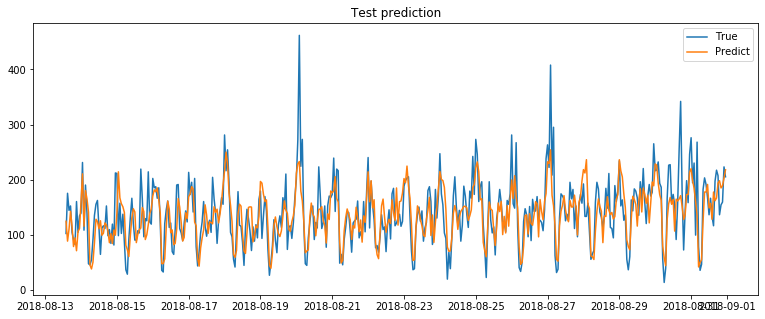

In [92]:
plt.figure(figsize=(13, 5))

plt.plot(y_test, label='True')
plt.plot(y_test.index, y_pred, label='Predict')

plt.title('Test prediction')
plt.legend()
plt.show()

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что предсказания были визуализированы.
</div>

### Вывод
- Для сравнения эффективности использовались модели градиентного бустинга, линейной регрессии и случайного леса
- Лучшая модель для данного предсказания из испробованых - LGBMRegressor
- корень среднеквадратичной ошибки выбранной модели на тестовой выборке - 40.22
- Это соответствует визуализированным отклонениям на графике

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48